# Everything you need to know about Logistic Regression

## Table of contents
* [Math behind logistic regression and implementation](#some-math)
    * [Problem definition](#problem-definition1)
    * [Functions](#functions1)
    * [Running the model with Gradient Descent](#running-gd)
    * [Running the model with BFGS algorithm](#running-bfgs)
    * [Make a prediction](#make-prediction)
* [Regularized logistic regression](#regularized)
    * [Problem definition](#problem-definition2)
    * [Feature mapping](#feature-mapping)
    * [Functions](#functions2)
    * [Running the model](#running)
* [Multiclass Classification: One-vs-all](#one-vs-all)
    * [Functions](#functions3)
    * [Train the model choosing the best lambda value](#best-lambda)
* [Compare our logistic regression to sklearn logistic regression](#compare-sklearn)
* [Compare logistic regression to SVM](#compare-svm) 

## Math behind logistic regression  and implementation <a class="anchor" id="some-math"></a>

Logistic regression, as linear regression, is an algorithm that falls into the category of *Supervised Learning*, which means that we have the label (dependent variable) for each training example.
Linear regression goal is to fit a straight line to the data, trying to capture what is the trend of the data (read my [article](http://petrupotrimba.altervista.org/image-post.php?id=1#img) about linear regression if you didn't). <br>
By contrast, the **logistic regression goal** is to find the best decision boundary that separates the data in different classes. <br>
In short, logistic regression answer you at questions like "**Is it a cat or dog?**".

Now let's deep dive into the math behind. <br>
As always, we have an *hypothesis* function and a *cost function* (or loss function) which we need to minimize using some optimization algorithm in order to find the best parameter that yields to the best decision boundary that separates our data into different classes.

The logistic regression hypothesis is defined as:

$$h_\theta(x) = g(\theta^Tx)$$ where $g$ is the sigmoid function: $$g(z) = \frac{1}{1+e^{-z}}$$

$g$ models the relationship between $p(x) = Pr(y=1|x)$ and $x$. As you can see, the equation relating the two variables is clearly non linear (it has to be like that as we want $g$ to follow the constraints of a Cumulative Distribution Function, i.e. with outputs constrained between 0 and 1 and with an inflection point at 0.5). It is interesting to notice that logistic regression is by definition a linear model. In what is it actually linear?

Turns out that one can show the following:

$$log(\frac{p(x)}{1 - p(x)}) = \theta^Tx$$

The quantity $\frac{p(x)}{1 - p(x)}$ is called the *odds*. The previous manipulation shows that the logistic regression model has a logit (log-odds) which is linear in $x$.

The coefficients $\theta$ are unknown and must be estimated based on the available training data. In the linear regression context we used the least squares approach, minimizing $J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 $. Within the logistic regression framework we need to do the same but we actually can't use the identical cost function definition as before, due to it not being convex (i.e. it would have many local minima). Hence we turn to the more general *maximum likelihood* method. This is the basic intuition behind it: we seek estimates for $\theta$ such that the predicted probability $p(x)$ of success (assuming a binary classification problem) for each observation, corresponds as closely as possible to the observation’s actual status (success/failure). In other words, we try to find $\theta$ such that plugging
these estimates into the model for $p(x)$, yields a number close to *one* for all individuals who successed, and a number close to *zero* for all individuals who did not. This intuition can be formalized using a mathematical equation called a likelihood function (which we need to maximize):

$l(\theta) = \prod_{i:y_1=1}p(x_i) \prod_{i:y_1=0}(1-p(x_i)) $

Computing the negative log of the whole equation and rearranging the terms leads us to the final cost function for the logistic regression model (which we now need to minimize):

$$J(\theta) = \frac{1}{m}\sum_{i=1}^m(-y_i log(h_i(\theta)) - (1-y_i)log(1-h_i(\theta)))$$

The model's parameters are the $\theta_j$ values. These are the values that need to be adjusted to minimize cost $J(\theta)$ . One way to do this is to use the batch gradient descent algorithm. In batch gradient descent, each iteration performs the update:

$$\theta_j := \theta_j - \frac{\alpha}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}$$ (simultaneously update $\theta_j$ for all $j$);
With each step of gradient descent, the parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost $J(\theta)$.

Note that while this gradient looks identical to linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

Now, to really understand how logistic regression works, let's implement it from scratch and apply it to a dummy exercise.

### Problem definition <a class="anchor" id="problem-definition1"></a>

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision. Your task is to build a classification model that estimates an applicant's probability of admission based the scores from those two exams.

Let's load the dataset. 

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 12)

In [76]:
students_exams = pd.read_csv('ex2data1.txt', 
                            header=None,
                            names=['FirstExamScore', 'SecondExamScore', 'Results'])
students_exams['Admission'] = np.where(students_exams['Results']==0, 'Not Admitted', 'Admitted')

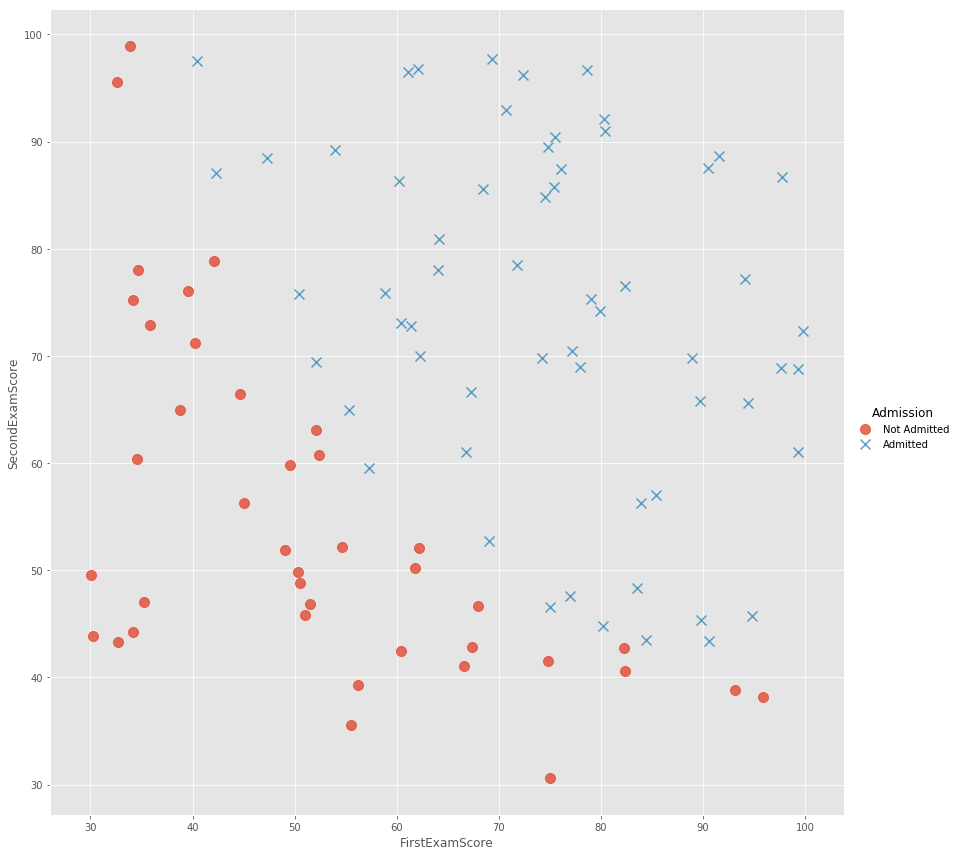

In [77]:
g = sns.lmplot("FirstExamScore", "SecondExamScore", hue="Admission", 
               data=students_exams, markers=["o", "x"], fit_reg=False, height=12, scatter_kws={"s": 100})

In [78]:
X = students_exams.iloc[:, 0:2]
# add bias term
X = np.c_[np.ones(X.shape[0]), X]
y = students_exams.iloc[:, 2:3]

### Functions <a class="anchor" id="functions1"></a>

Here I implemented the necessary function for run logistic regression along with some utility function to plot the result.

In [79]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def costFunction(theta, X, y):
    m = y.shape[0]
    h = sigmoid(np.dot(theta.T, X.T))
    cost = (1/m)*(np.dot(-y.T,np.log(h).T) - np.dot((1-y).T,np.log(1-h).T))
    if np.isnan(cost):
        return np.inf
    return cost

def computeGradient(theta, X, y):
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    h = sigmoid(np.dot(theta.T, X.T))
    gradient = (1/m)*(np.dot((h.T-y).T, X))
    return gradient.flatten()

def gradientDescent(X, y, theta, alpha, iterations):
    m = y.shape[0]
    J_history = np.zeros((iterations, 1))
    for i in range(iterations):
        hypothesis_minus_y = (sigmoid(np.dot(theta.T, X.T).T)-y).T 
        theta = (theta.T - (alpha/m)*(np.dot(hypothesis_minus_y, X))).T 
        J_history[i] = costFunction(theta, X, y)
    return theta, J_history

def plotDecisionBoundary(X, theta):
    plotx = np.array([min(X[:,1])-2, max(X[:,1])+2])
    ploty = -(theta[1] * plotx + theta[0])/theta[2]
    return plotx, ploty

def predict(X, theta):
    prob = sigmoid(X.dot(theta))
    p = np.where(prob < 0.5, 0, 1)
    return p.reshape(-1, 1)

### Running the model with Gradient Descent <a class="anchor" id="running-gd"></a>

In [80]:
theta = np.array([-25, 0.2, 0.2]).reshape(-1, 1)                                               
iterations =400
alpha = 0.001
theta, J_history = gradientDescent(X, y, theta, alpha, iterations)
print("Theta found by gradient descent: intercept={0}, slope={1}, slope={2} ".format(theta[0],theta[1], theta[2]))

Theta found by gradient descent: intercept=[-24.99997875], slope=[0.20494106], slope=[0.20016601] 


In order to know if our implementation of Gradient Descent is correct, we use the `check_grad` function which compare our implementation against a (forward) finite-difference approximation of the gradient. If the difference between our implementation and the finite-difference approximation of the gradient is small, that means that our implementatio is correct! <br>
Let's figure it out!

In [81]:
from scipy.optimize import check_grad
check_grad(costFunction, computeGradient, theta.squeeze(), X, y)

2.7219429489882173e-06

As we can see, the error is small, great!

Another useful check to do is to look at the values of cost function for each iterations. <br>
We should see that the cost is decreasing at each iteration until it converges to a value.

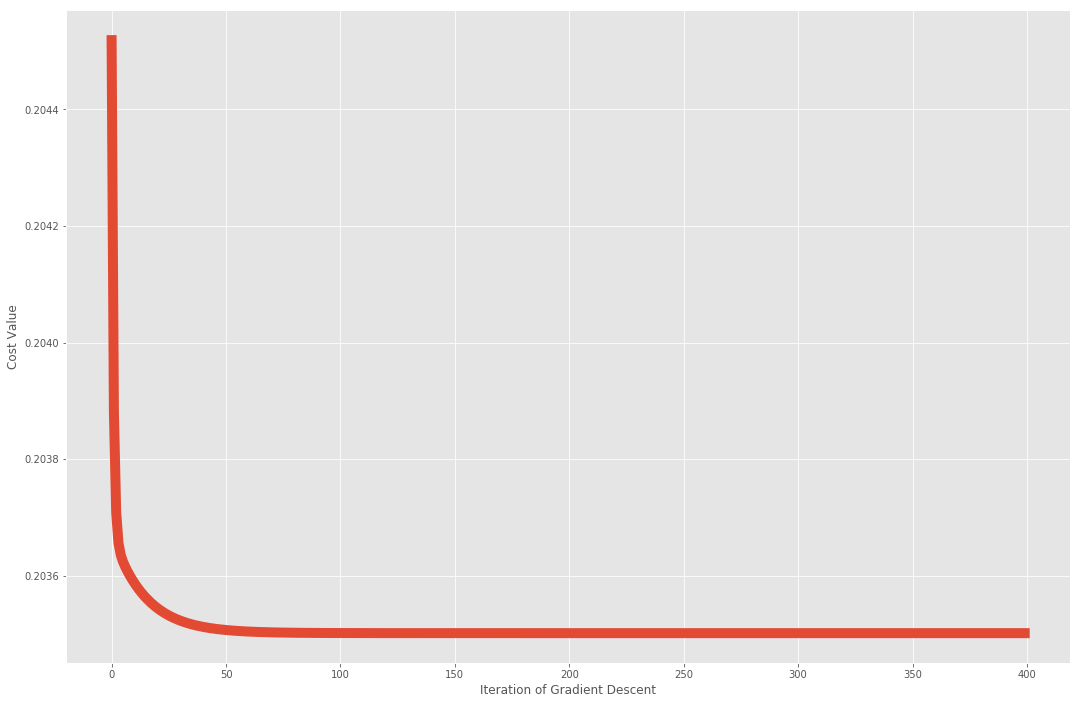

In [82]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(iterations), J_history, linewidth=6)
plt.ylabel('Cost Value')
plt.xlabel('Iteration of Gradient Descent')
plt.show()

Fine, the cost is decreasing. <br>
Now we are ready to plot the decision boundary we learned.

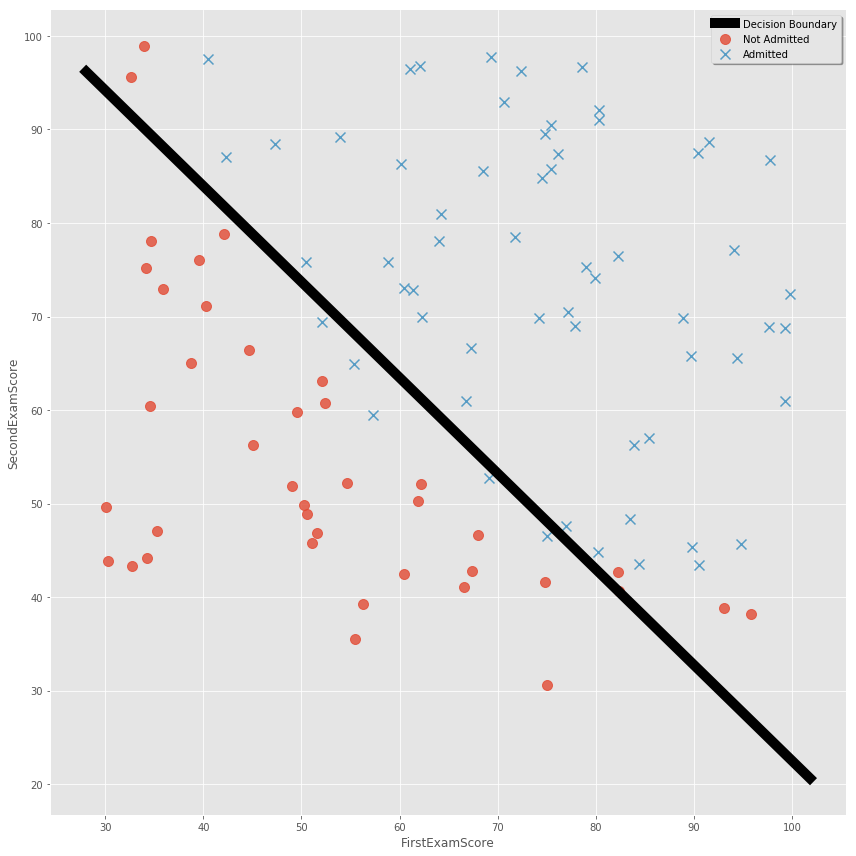

In [83]:
plotx, ploty= plotDecisionBoundary(X, theta)
g = sns.lmplot("FirstExamScore", "SecondExamScore", hue="Admission", 
               data=students_exams, markers=["o", "x"], fit_reg=False, height=12, legend=False, scatter_kws={"s": 100})
ax = g.ax
ax.plot(plotx, ploty, color='k', label='Decision Boundary', linewidth=6)
legend = ax.legend(loc=1, shadow=True)
plt.show()

In [84]:
prob = predict(X, theta)
p = np.where(prob == y, 1, 0)
print("Model accuracy: ", p.sum()/y.shape[0] * 100, "%")

Model accuracy:  89.0 %


### Running the model with  BFGS algorithm <a class="anchor" id="running-bfgs"></a>

Sometimes gradient descent get stock in a different local optima and does not return the best parameter for our model, i.e. the model accuracy is not so good.
To find out if is it the case, we are going to use a different minimization algorithm and look if the accuracy alters. <br>
In this case we use *Broyden–Fletcher–Goldfarb–Shanno* algorithm (BFGS algorithm).

In [85]:
from scipy import optimize
initial_theta = np.array([0.0, 0.0, 0.0]).T
theta = optimize.fmin_bfgs(f=costFunction, x0=initial_theta, args=(X, y), fprime=computeGradient)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 25
         Function evaluations: 34
         Gradient evaluations: 30


/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


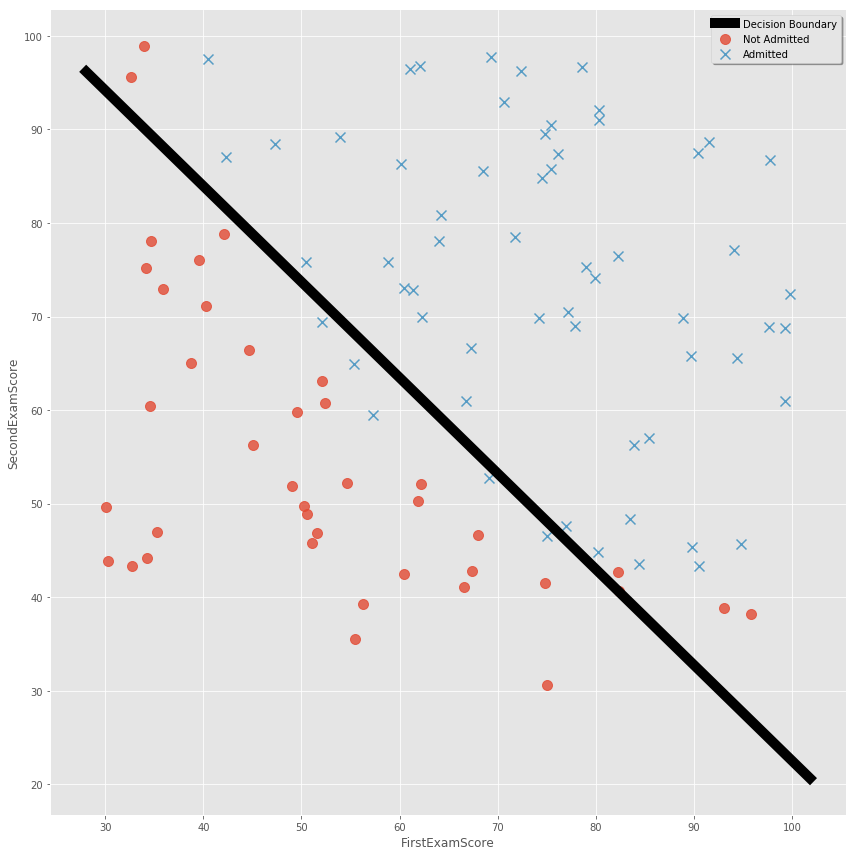

In [86]:
plotx, ploty= plotDecisionBoundary(X, theta)
g = sns.lmplot("FirstExamScore", "SecondExamScore", hue="Admission", 
               data=students_exams, markers=["o", "x"], fit_reg=False, height=12, legend=False, scatter_kws={"s": 100})
ax = g.ax
ax.plot(plotx, ploty, color='k', label='Decision Boundary', linewidth=6)
legend = ax.legend(loc=1, shadow=True)
plt.show()

In [87]:
prob = predict(X, theta)
p = np.where(prob == y, 1, 0)
print("Model accuracy: ", p.sum()/y.shape[0] * 100, "%")

Model accuracy:  89.0 %


The accuracy remains the same, that means that our gradient descent actually found the global optima, i.e. the best parameter for our model.

### Make a prediction <a class="anchor" id="make-prediction"></a>

For a student with an Exam 1 score of 45 and Exam 2 score of 85, his admission probability is 0.776.

In [88]:
X = np.array([1, 45, 85])
sigmoid(X.dot(theta))

0.7762903249331021

# Regularized logistic regression <a class="anchor" id="regularized"></a>

In this section we are going to face the problem where a dataset cannot be separated into a positive and negative examples by a simple straight-line.

### Problem definition <a class="anchor" id="problem-definition2"></a>

We will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [89]:
micro = pd.read_csv('ex2data2.txt', 
                            header=None,
                            names=['MicrochipTest1', 'MicrochipTest2', 'Results'])
micro['QA'] = np.where(micro['Results']==0, 'Rejected', 'Accepted')

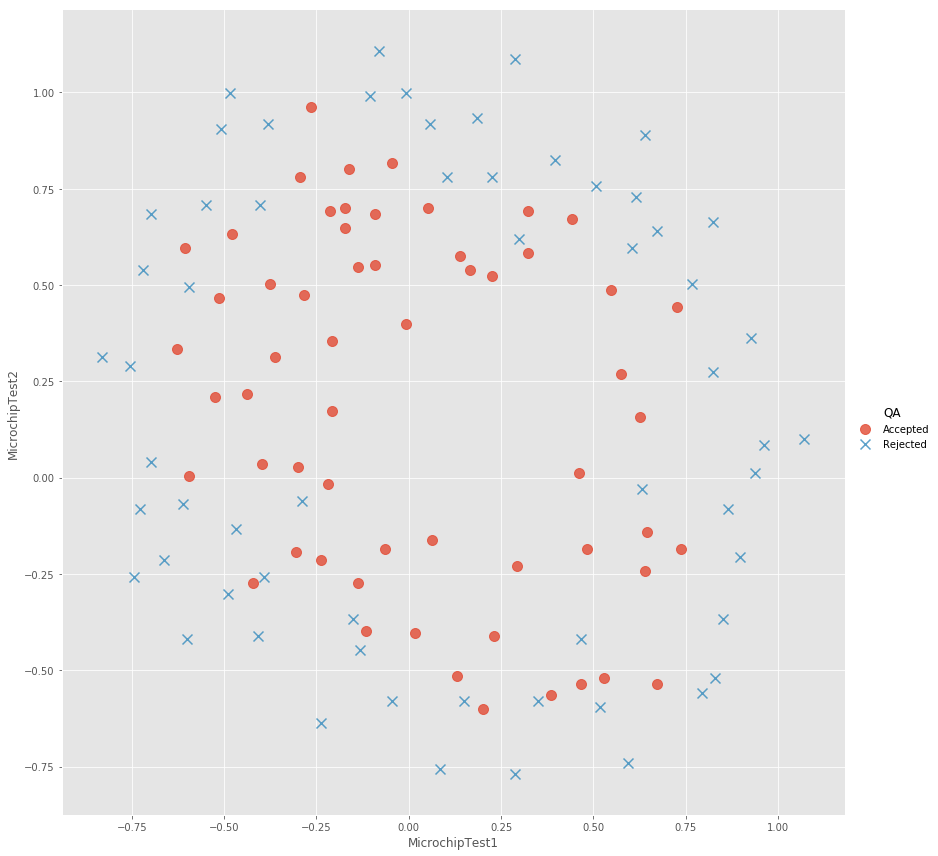

In [90]:
g = sns.lmplot("MicrochipTest1", "MicrochipTest2", hue="QA", 
               data=micro, markers=["o", "x"], fit_reg=False, height=12, scatter_kws={"s": 100})

This dataset cannot be separated into a positive and negative examples by a straight-line through the plot. Therefore, a straight forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### Feature mapping <a class="anchor" id="feature-mapping"></a>

One way to fit the data better is to create more features from each data point. We will map the features into all polynomial terms of $x1$ and $x2$ up to the **sixth** power.
Doing so we take care of the low bias of the model, but we will also introduce inevitably much more variance (if you are somewhat confused about bias-variance tradeoff, checkout my [article](http://petrupotrimba.altervista.org/image-post.php?id=2#img)). We will combat this second term using regularization.

Applying a regularization terms the cost function looks like this:
$$J(\theta) = \frac{1}{m}\sum_{i=1}^m(-y_i log(h_i(\theta)) - (1-y_i)log(1-h_i(\theta))) + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$

We need to keep in mind that the we don't have to regularize $\theta_0$, which refers to the first feature we artificially set to 1. Hence the gradient of the cost will look like the following:

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} $ for $j=0$ 

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m}\sum_{j=1}^n\theta_j$ for $j\geq1$

In [91]:
def mapFeature(X1, X2, degree):
    '''
    mapFeature(X1, X2, degree): maps the two input features to quadratic features.
    
    Returns a new feature array with more features, comprising of 
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Inputs X1, X2 must be the same size
    '''
    X = np.ones(X1.shape[0])
    for i in np.arange(degree+1):
        for j in np.arange(i+1):
            X = np.c_[X, np.power(X1, i-j) * np.power(X2, j)]
    return X


As a result of this mapping, our vector of two featues (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear non-linear when drawn in out 2-dimensional plot.

### Functions <a class="anchor" id="functions2"></a>

In [92]:
def costFunctionReg(theta, X, y, lamb):
    h_theta = sigmoid(X.dot(theta))

    cost = (np.dot(np.log(h_theta).T, -y) + np.dot(np.log(1-h_theta).T, -(1-y))) + lamb/2 * (theta[1:,]**2).sum()
    
    return np.asscalar(cost.squeeze())

def computeGradientReg(theta, X, y, lamb):
    theta = theta.reshape(-1, 1)
    h_theta = sigmoid(X.dot(theta))
    
    gradient = np.dot(X.T, h_theta - y)
    gradient[1:] += lamb * theta[1:,]
    
    return gradient.flatten()

def plotDecisionBoundaryReg(X, theta, ax):
    # generating an evenly spaced grid to evaluate the classifier's predictions
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    
    z = np.zeros((len(u), len(v)));
    # Evaluate z = theta*x over the grid
    for i in np.arange(len(u)):
        for j in np.arange(len(v)):
            z[i,j]= np.dot(mapFeature(np.atleast_1d(u[i]).reshape(-1,1), np.atleast_1d(v[j]).reshape(-1,1), 6), theta)
    
    cs = ax.contour(u, v, z.T, levels=[0], colors='k', linewidths=6)
    plt.clabel(cs,  
               inline=1,
               fmt='%1.2f',
               fontsize=14)
    plt.show()
    return z

### Running the model <a class="anchor" id="running"></a>

In [93]:
data = np.loadtxt('ex2data2.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2]
y = y.reshape(y.shape[0], 1)

# mapping features into all polynomial terms of X1 and X2 up to the sixth power
X_expanded = mapFeature(X[:,0], X[:,1], 6)

initial_theta = np.zeros((X_expanded.shape[1], 1))

Optimization terminated successfully.
         Current function value: 25.876267
         Iterations: 342
         Function evaluations: 344
         Gradient evaluations: 344


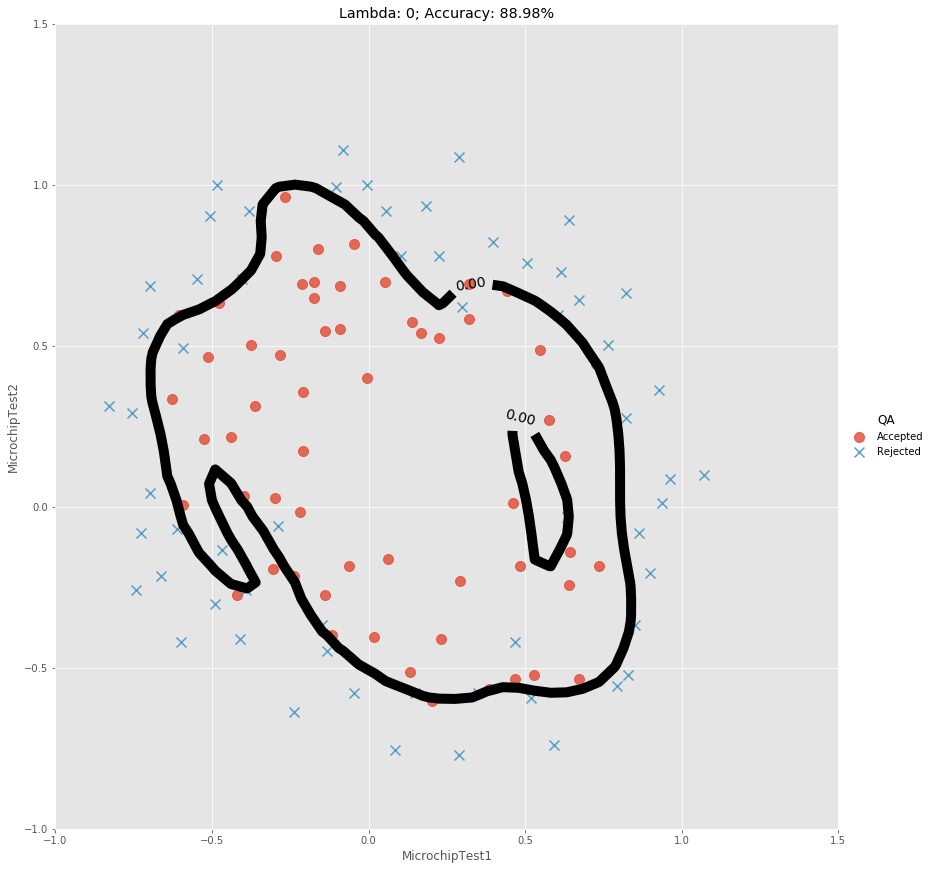

Optimization terminated successfully.
         Current function value: 62.422322
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18


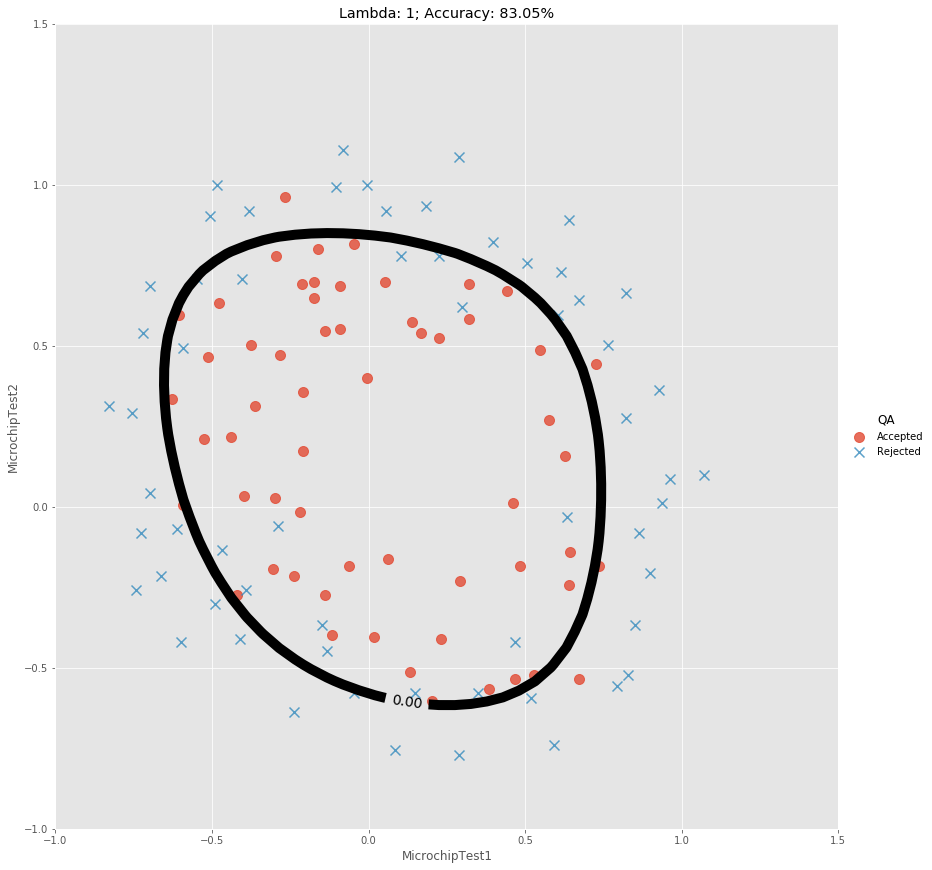

Optimization terminated successfully.
         Current function value: 76.489453
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28


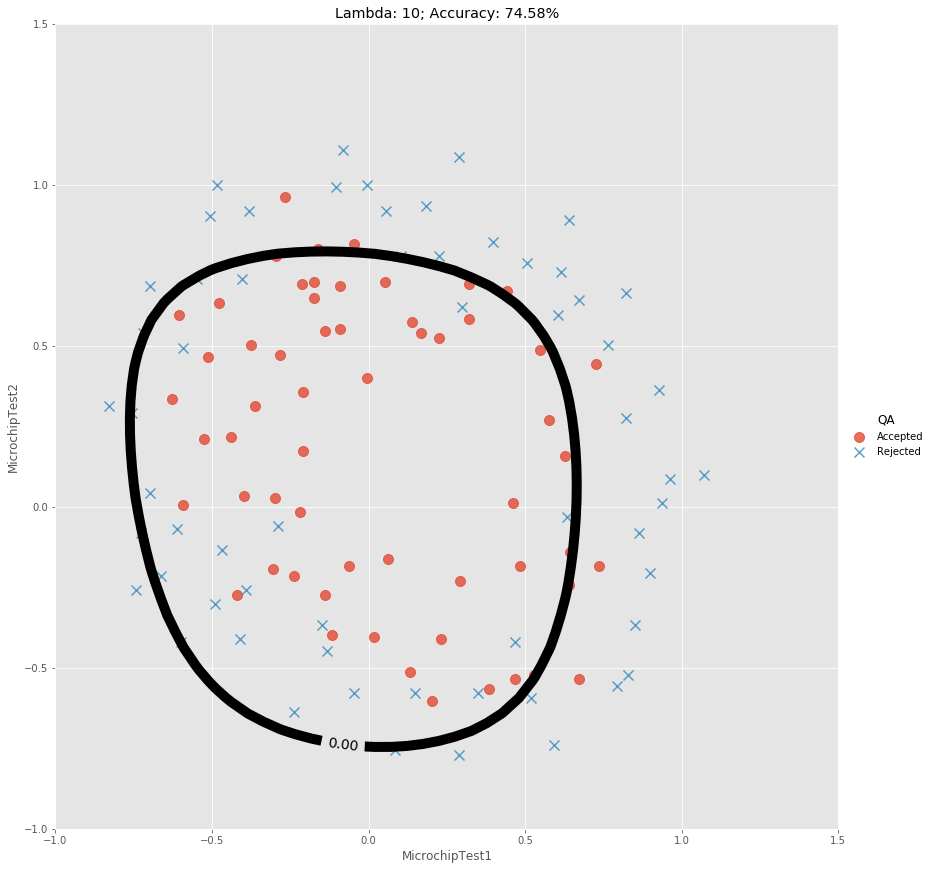

Optimization terminated successfully.
         Current function value: 81.005092
         Iterations: 22
         Function evaluations: 36
         Gradient evaluations: 36


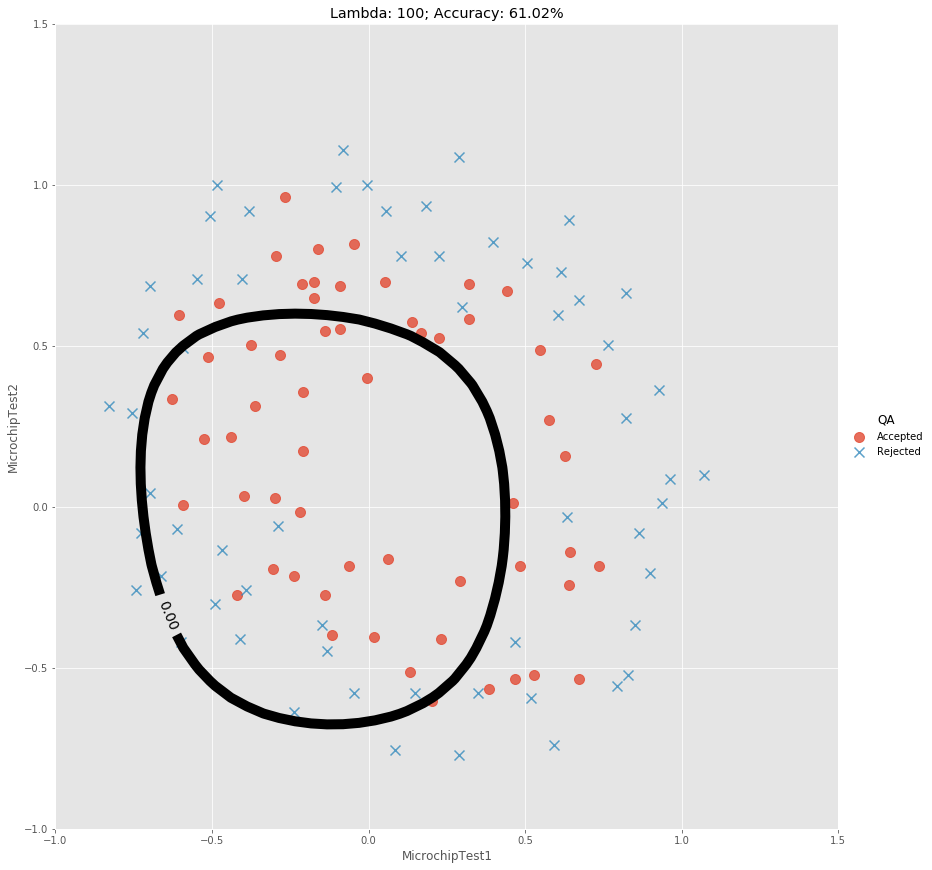

In [94]:
from scipy import optimize
lamda_values = [0, 1, 10, 100]
for lamda in lamda_values:
    theta = optimize.fmin_bfgs(f=costFunctionReg, x0=initial_theta, args=(X_expanded, y, lamda), fprime=computeGradientReg)
    # plot
    g = sns.lmplot("MicrochipTest1", "MicrochipTest2", hue="QA", 
               data=micro, markers=["o", "x"], fit_reg=False, height=12, scatter_kws={"s": 100})
    ax = g.ax
    accuracy= np.where(y == predict(X_expanded, theta), 1, 0).sum()/y.shape[0] * 100
    ax.set_title('Lambda: {0}; Accuracy: {1}%'.format(lamda, round(accuracy, 2)))
    z = plotDecisionBoundaryReg(X, theta, ax)


# Multiclass Classification: One-vs-all <a class="anchor" id="one-vs-all"></a>

Now we will approach the classification of data when we have more than two categories. Instead of $y = \{0,1\}$ we will expand our definition so that $y = \{0,1...n\}$.

Since $y = \{0,1...n\}$, we divide our problem into $n+1$ (+1 because the index starts at 0) binary classification problems; in each one, we predict the probability that $y$ is a member of one of our classes.

$y\in \{0, 1...n\}$ <br>
$h_\theta^{(0)}(x)$ = $P(y = 0 | x; \theta)$ <br>
$h_\theta^{(1)}(x)$ = $P(y = 1 | x; \theta)$ <br>
$\dots$ <br>
$h_\theta^{(n)}(x)$ = $P(y = n | x; \theta)$ <br>
prediction = $\max_i(h_\theta^{(i)}(x))$

We are basically choosing one class and then lumping all the others into a single second class. We do this repeatedly, applying binary logistic regression to each case, and then use the hypothesis that returned the highest value as our prediction.

<img src="img/onevsall.png" width="80%" height="auto">

To summarize:

Train a logistic regression classifier $h_\theta(x)$ for each class￼ to predict the probability that ￼$￼y = i$￼.

To make a prediction on a new $x$, pick the class ￼that maximizes $h_\theta(x)$.

In [95]:
import scipy.io
from scipy import optimize
import random
from sklearn.model_selection import train_test_split

mat = scipy.io.loadmat('ex3data1.mat')
X = mat['X']
y = mat['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Functions <a class="anchor" id="functions3"></a>

In [96]:
def displayData(X):
    fig = plt.figure(figsize=(14,14))
    plt.title('100 Random Images from the data set')
    indexes = random.sample(range(1, X.shape[0]), 100)
    images = X[indexes,:]
    for i in np.arange(10):
        for j in np.arange(10):
            ax = fig.add_subplot(10, 10, (10*j+i)+1)
            ax.matshow(images[10*j+i,:].reshape(20,20), cmap = 'gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()
    
def displaySigleDigit(X):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(X.reshape(20,20), cmap = 'gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.title('1 Random Digit from the data set')
    plt.show()
    
def oneVsAll(X, y, num_labels, lamda):
    m = X.shape[1]
    all_theta = np.zeros((m + 1, num_labels)) #(401, 10) +1 is for interceptor therm
    y_copy = y
    X = np.c_[np.ones((X.shape[0], 1)), X]
    for k in np.arange(num_labels):
        initial_theta = np.zeros((1, m + 1)).reshape(-1, 1) # +1 is for interceptor therm
        y_copy = np.where(y != k + 1, 0, k + 1)
        #theta = optimize.fmin_bfgs(f=costFunctionReg, x0=initial_theta.squeeze(), args=(X, y_copy, lamda), fprime=computeGradientReg)
        theta = optimize.minimize(fun=costFunctionReg, x0=initial_theta.squeeze(), args=(X, y_copy, lamda),
                                  method='TNC', jac=computeGradientReg, options=dict(disp=True, maxiter=100000))
        all_theta[:, k] = theta.x
    return all_theta
    

def predictOneVsAll(theta, X):
    X = np.c_[np.ones((X.shape[0], 1)), X]
    return sigmoid(X.dot(theta))

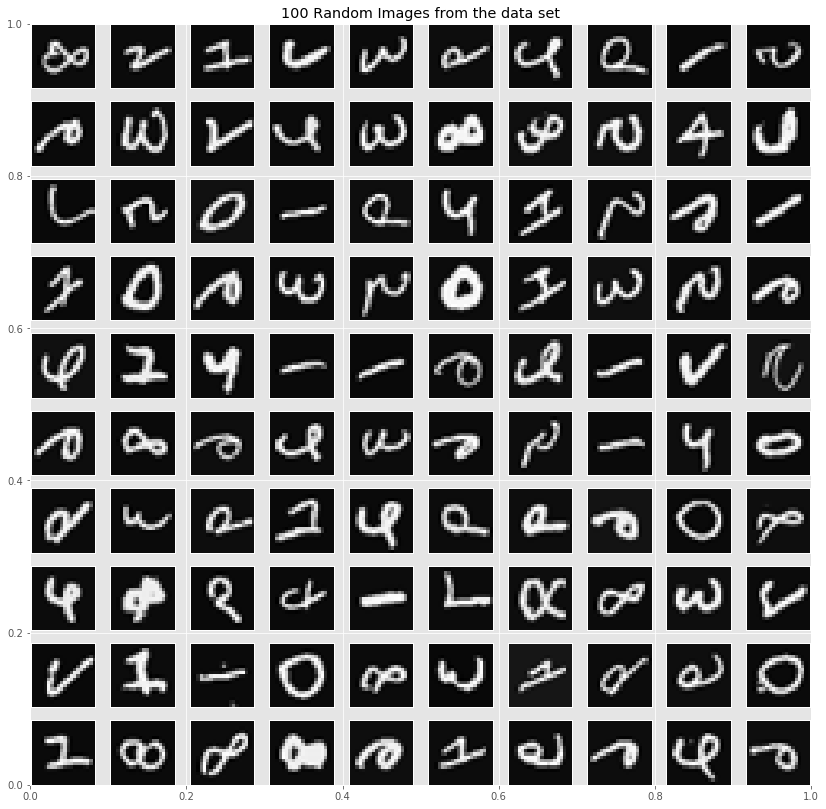

In [97]:
displayData(X_train)

### Train the model choosing the best lambda value <a class="anchor" id="best-lambda"></a>

In [98]:
num_labels = 10
accuracy = np.array([])

for lamda in [0, 0.1, 10, 100]:
    all_theta = oneVsAll(X_train, y_train, num_labels, lamda)
    prob = predictOneVsAll(all_theta, X_test)
    pred = np.argmax(prob, axis=1) + 1
    p = np.where(pred.reshape(-1, 1) == y_test, 1, 0)
    accuracy = np.append(accuracy, (p.sum()/y_test.shape[0]) * 100)

print("Accuracy: ", accuracy.max())

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Accuracy:  83.5


### Compare our logistic regression to sklearn logistic regression <a class="anchor" id="compare-sklearn"></a>

In [99]:
import scipy.io
from scipy import optimize
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

mat = scipy.io.loadmat('ex3data1.mat')
X = mat['X']
y = mat['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [100]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train.ravel())

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [101]:
print("Accuracy: ", clf.score(X_test, y_test) * 100)

Accuracy:  91.2


The value to predict is:

In [102]:
y_test[0][0]

8

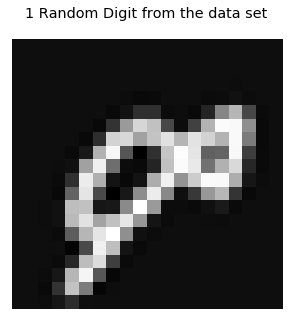

In [103]:
displaySigleDigit(X_test[0, :].reshape(-1, 1).T)

The predicted value is:

In [104]:
clf.predict(X_test[0, :].reshape(-1, 1).T)[0]

8

### Compare logistic regression to SVM <a class="anchor" id="compare-svm"></a>

In [105]:
from sklearn import svm

mat = scipy.io.loadmat('ex3data1.mat')
X = mat['X']
y = mat['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [106]:
clf = svm.SVC(kernel='rbf', C=1.0)
clf.fit(X_train, y_train.ravel())
#accuracy = (clf.predict(X_test).reshape(-1,1) == y_test.reshape(-1,1)).sum()/y_test.shape[0]
print("Accuracy: ", clf.score(X_test, y_test) * 100)

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy:  92.5
